# Lab 6: Geospatial analysis using python (9 pts)

**Due:** Nov 19, 2024 10:00 PM CDT

## Learning Objectives

- We will explore the capabilities of GDAL-based Python functionalities to develop a Zonal Statistic workflow.

- The goal is to find out the total planting area of different crops within each county of Missouri from the Cropland Data Layer (CDL) data (https://nassgeodata.gmu.edu/CropScape/).

## Data

Dataset are provided in Canvas. For this demo workflow, you will use the `cb_2018_us_county_20m.zip` as the county shape and the `CDL_2023_clip_20241030205700_384619517.zip` as the CDL data. However, for your part, use the `lab-6-task-data.zip`, which contains both the raster and vector data for the state of Illinois.

## Demonstration

Download all the data, unzip it, and upload the data to your Google Drive. Use a lab specific directory for all your work. Then we need to mount this notebook to that google drive. Run the following codes and provide necessary permission so this notebook can access your google drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Next, we need to install necesary geospatial libraries within this session. Run the following command line to install [rasterio](https://rasterio.readthedocs.io/en/stable/) and [geopandas](https://geopandas.org/en/stable/).

In [2]:
!pip install rasterio geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 27.7 MB/s eta 0:00:00


Import all the necessary modules.

In [3]:
import rasterio
import rasterio.mask
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Read the raster data using rasterio. You can navigate to the left of the screen (the folder icon) and find where you have already uploaded all the data. Find the appropriate `.tif` file and copy the full path of it by clicking the three dots next to it.

In [4]:
# reading image as rasterio object
src = rasterio.open('/content/drive/MyDrive/GIS5120/lab-6/data/CDL_2023_clip_20241030205700_384619517/CDL_2023_clip_20241030205700_384619517.tif')

In [5]:
# let's examine the metadata of the raster (this will NOT load the data into memory)
src.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 22112, 'height': 19692, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, -28365.0,
       0.0, -30.0, 2003985.0), 'blockxsize': 22112, 'blockysize': 1, 'tiled': False, 'interleave': 'band'}

In [6]:
# read the data as np array (this will load the data into memory)
img = src.read()

In [7]:
# whenever working with arrays, if creating or changing it, always check its shape
img.shape

(1, 19692, 22112)

Let's look at the first 500 rows and 500 columns of the image by slicing it. Note that we are just doing this for visualization. It does not change our array.

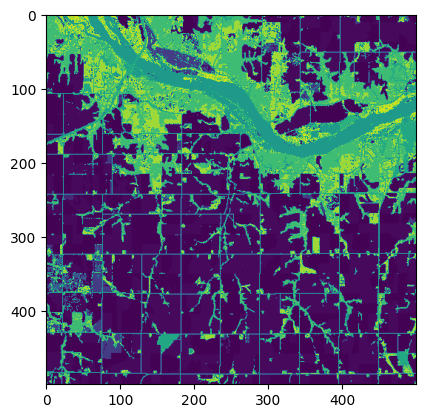

In [8]:
plt.imshow(img[0, :500, :500])
plt.show()

We are interested in only '1' and '5', which represents the corn and soybean, respectively. We will work on that later. Raster looks good.

Open the county shapefile and examine it.

In [9]:
# reading county shape
county = gpd.read_file('/content/drive/MyDrive/GIS5120/lab-6/data/cb_2018_us_county_20m/cb_2018_us_county_20m.shp')

In [10]:
county

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,37,017,01026336,0500000US37017,37017,Bladen,06,2265887723,33010866,"POLYGON ((-78.902 34.83527, -78.7996 34.85086,..."
1,37,167,01025844,0500000US37167,37167,Stanly,06,1023370459,25242751,"POLYGON ((-80.49737 35.2021, -80.29542 35.5029..."
2,39,153,01074088,0500000US39153,39153,Summit,06,1069181981,18958267,"POLYGON ((-81.68699 41.13596, -81.68495 41.277..."
3,42,113,01213687,0500000US42113,42113,Sullivan,06,1165338428,6617028,"POLYGON ((-76.81373 41.59003, -76.22014 41.541..."
4,48,459,01384015,0500000US48459,48459,Upshur,06,1509910100,24878888,"POLYGON ((-95.15274 32.66095, -95.15211 32.902..."
...,...,...,...,...,...,...,...,...,...,...
3215,38,005,01034216,0500000US38005,38005,Benson,06,3596569006,131708143,"POLYGON ((-99.84661 48.3713, -99.49292 48.3709..."
3216,72,079,01804520,0500000US72079,72079,Lajas,13,155287827,106643202,"POLYGON ((-67.10904 18.05608, -67.06791 18.066..."
3217,31,159,00835901,0500000US31159,31159,Seward,06,1479995670,11542537,"POLYGON ((-97.36812 41.04695, -96.91094 41.046..."
3218,37,023,01008539,0500000US37023,37023,Burke,06,1311146878,20719896,"POLYGON ((-81.90665 35.88338, -81.94319 35.960..."


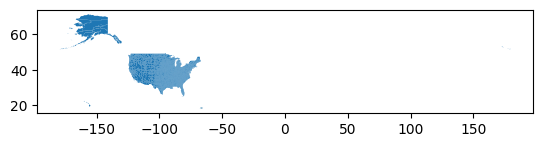

In [11]:
# let's plot it
county.plot()
plt.show()

We need only the counties within Missouri. By a simple google search, we know that the FIPS code of Missouri is 29. Note that the `STATEFP` column has the FIPS code, but it's in string. Filter it and find only the Missouri counties.

In [12]:
# filter out only counties that are within Missouri
mo_county = county[county['STATEFP'] == '29']

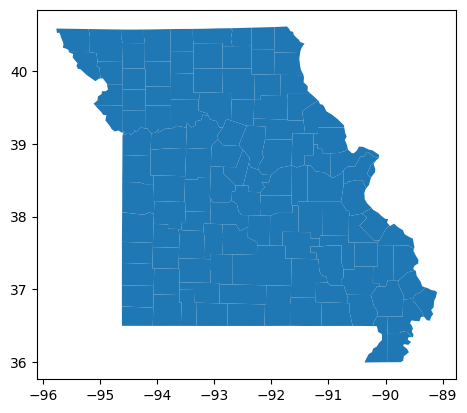

In [13]:
# let's have a look
mo_county.plot()
plt.show()

Before moving on to zonal statistics, we need to make sure both our data share the same projection system. We can look into the CRS information from both the raster and vector data.

In [14]:
# vector data
mo_county.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [15]:
# find out raster epsg code
src.crs.to_epsg()

5070

Turns out they are different. We can quickly reproject the vector data crs to match the raster data crs as it is more efficient compared to raster reprojection. Also, it's good to perform geospatial operations in projected coordinate system at this scale (depends on specific situations though).

In [16]:
# reproject the vounty shapefile to match the raster crs
mo_county_proj = mo_county.to_crs('EPSG: 5070')

In [17]:
# let's have a look
mo_county_proj

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
16,29,175,00758542,0500000US29175,29175,Randolph,06,1250217892,13254191,"POLYGON ((280999.401 1846780.552, 281382.341 1..."
88,29,027,00758468,0500000US29027,29027,Callaway,06,2161515126,33192502,"POLYGON ((325828.974 1749396.534, 332359.902 1..."
101,29,097,00758503,0500000US29097,29097,Jasper,06,1653724865,7162363,"POLYGON ((121541.679 1569591.813, 121303.752 1..."
113,29,031,00758470,0500000US29031,29031,Cape Girardeau,06,1498398269,20174864,"POLYGON ((536495.415 1635247.475, 559041.831 1..."
118,29,117,00758513,0500000US29117,29117,Livingston,06,1378644691,16200765,"POLYGON ((189476.949 1884676.651, 223310.214 1..."
...,...,...,...,...,...,...,...,...,...,...
3082,29,510,00767557,0500000US29510,29510,St. Louis,25,159915148,11211123,"POLYGON ((489896.484 1744727.235, 494815.05 17..."
3084,29,205,00758555,0500000US29205,29205,Shelby,06,1297230222,3764606,"POLYGON ((314257.202 1887792.596, 323602.379 1..."
3144,29,047,00758478,0500000US29047,29047,Clay,06,1029948190,28501892,"POLYGON ((119295.335 1826912.818, 152561.756 1..."
3146,29,079,00758494,0500000US29079,29079,Grundy,06,1127401335,7118004,"POLYGON ((188559.883 1918773.571, 221938.271 1..."


Since the index of the filtered data are all from the main county dataframe, we can reindex it.

In [18]:
# reset the index
mo_county_proj = mo_county_proj.reset_index(drop=True)

In [19]:
# let's look
mo_county_proj

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,29,175,00758542,0500000US29175,29175,Randolph,06,1250217892,13254191,"POLYGON ((280999.401 1846780.552, 281382.341 1..."
1,29,027,00758468,0500000US29027,29027,Callaway,06,2161515126,33192502,"POLYGON ((325828.974 1749396.534, 332359.902 1..."
2,29,097,00758503,0500000US29097,29097,Jasper,06,1653724865,7162363,"POLYGON ((121541.679 1569591.813, 121303.752 1..."
3,29,031,00758470,0500000US29031,29031,Cape Girardeau,06,1498398269,20174864,"POLYGON ((536495.415 1635247.475, 559041.831 1..."
4,29,117,00758513,0500000US29117,29117,Livingston,06,1378644691,16200765,"POLYGON ((189476.949 1884676.651, 223310.214 1..."
...,...,...,...,...,...,...,...,...,...,...
110,29,510,00767557,0500000US29510,29510,St. Louis,25,159915148,11211123,"POLYGON ((489896.484 1744727.235, 494815.05 17..."
111,29,205,00758555,0500000US29205,29205,Shelby,06,1297230222,3764606,"POLYGON ((314257.202 1887792.596, 323602.379 1..."
112,29,047,00758478,0500000US29047,29047,Clay,06,1029948190,28501892,"POLYGON ((119295.335 1826912.818, 152561.756 1..."
113,29,079,00758494,0500000US29079,29079,Grundy,06,1127401335,7118004,"POLYGON ((188559.883 1918773.571, 221938.271 1..."


In the following segment, we can run a `for` loop through the entire dataframe. In each iteration, we are basically clipping/masking based on each county shape/geometry and then counting the number of pixels that belongs to certain crops. If we multiply that number with 900 sq meters (since the pixel size is 30 m), we can get the area in sq meters. Recall, how er did that in the class, break down your code intro several steps and then compile all together.

In [20]:
# create empty lists to hold masked information
corn_areas = []
soy_areas = []
county_fps = []

# run for loop
for i, row in mo_county_proj.iterrows():
  # mask the image based on county geometry
  out_image, out_transform = rasterio.mask.mask(
      dataset=src,
      shapes=[row['geometry']],
      crop=True
  )
  # take only the first band
  masked_arr = out_image[0, :, :]
  # find the corn and soy pixels, 1s true, 0s false
  corn_mask = (masked_arr == 1) * 1
  soy_mask = (masked_arr == 5) * 1
  # calculate area by multiplying with 900 (30*30) sq m
  corn_area = np.count_nonzero(corn_mask) * 900
  soy_area = np.count_nonzero(soy_mask) * 900

  # append it to the list
  corn_areas.append(corn_area)
  soy_areas.append(soy_area)
  county_fps.append(row['COUNTYFP'])

We got all the information in three different lists. Let's create a dataframe out of it.

In [21]:
crop_area = pd.DataFrame(
    {
        'county_fp': county_fps,
        'corn_area': corn_areas,
        'soy_area': soy_areas
    }
)

Since we have the same county fips from this `crop_area` geodataframe and the `mo_county_proj` geodataframe, we can merge them. This is same as `Join` tool in ArcGIS.

In [22]:
mo_crop_area_shp = pd.merge(
    mo_county_proj,
    crop_area,
    left_on='COUNTYFP',
    right_on='county_fp'
)

In [23]:
# let's check it
mo_crop_area_shp

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,county_fp,corn_area,soy_area
0,29,175,00758542,0500000US29175,29175,Randolph,06,1250217892,13254191,"POLYGON ((280999.401 1846780.552, 281382.341 1...",175,112508100,204074100
1,29,027,00758468,0500000US29027,29027,Callaway,06,2161515126,33192502,"POLYGON ((325828.974 1749396.534, 332359.902 1...",027,146802600,216882000
2,29,097,00758503,0500000US29097,29097,Jasper,06,1653724865,7162363,"POLYGON ((121541.679 1569591.813, 121303.752 1...",097,151137900,92030400
3,29,031,00758470,0500000US29031,29031,Cape Girardeau,06,1498398269,20174864,"POLYGON ((536495.415 1635247.475, 559041.831 1...",031,125778600,258237900
4,29,117,00758513,0500000US29117,29117,Livingston,06,1378644691,16200765,"POLYGON ((189476.949 1884676.651, 223310.214 1...",117,191226600,411533100
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,29,510,00767557,0500000US29510,29510,St. Louis,25,159915148,11211123,"POLYGON ((489896.484 1744727.235, 494815.05 17...",510,20700,57600
111,29,205,00758555,0500000US29205,29205,Shelby,06,1297230222,3764606,"POLYGON ((314257.202 1887792.596, 323602.379 1...",205,227099700,414627300
112,29,047,00758478,0500000US29047,29047,Clay,06,1029948190,28501892,"POLYGON ((119295.335 1826912.818, 152561.756 1...",047,73563300,95038200
113,29,079,00758494,0500000US29079,29079,Grundy,06,1127401335,7118004,"POLYGON ((188559.883 1918773.571, 221938.271 1...",079,166574700,272295900


Save this geodataframe as a `.shp` file into your google drive. You can later download it in your compter and use ArcGIS to create maps.

In [24]:
mo_crop_area_shp.to_file('/content/drive/MyDrive/GIS5120/lab-6/mo_crop_area.shp')

Remember to close the rasterio object that you have opened.

In [25]:
src.close()

# Your Task

1. Use the provided CDL data layer for Illinois (as `Illinois_CDL.tif` in `lab-6-task-data.zip`) to do the same task. You can use the same county shape. Create two choropleth map of corn and soybean areas in 2023 using ArcGIS pro after you create the shape file. (4.5 pts)

2. Instead of the plain inline code, create a function that takes any single band raster path and a shapefile path as input arguments. The function should return a dataframe that calculates the mean and standard deviation of all the polygon features in the provided shapefile path. The input shapefile must have a unique ID column which can be later joined with the output dataframe. For this task, you will find two datasets, i.e., `ndvi.tif` which shows the [NDVI](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) values as single band and `grid.geojson` as the vector or zones. Look at the next cell to get ideas about how the function might look like. (4.5 pts)

# Your Deliverables

1. Notebook with all the outputs for the Illinois task.
2. Two maps created in ArcGIS.
3. Notebook with all the outputs for the function task.

**Bonus point oppotunities:**
- Your function should automatically consider the fact of CRS mismatch. (Hint: use `if-else`). (1 pts)
- Create a nice structured github repository as public and share the code. You cannot just upload everything to github. You will only get the bonus point if you could do that from command line. I could verify that from your git hisotry. (2 pts)

In [26]:
# YOUR FUNCTION STRUCTURE

def zonal_statistics(raster_path, vector_path):

    return None